In [6]:
import os
import pandas as pd
import numpy as np
import re
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt


In [7]:

# Match Date
def get_datetime(text: str):
    try:
        date = datetime.strptime(text, '%d/%m/%Y')
    except Exception:
        date = datetime.strptime(text, '%d/%m/%y' )
    return date


In [8]:

# Goal Statistics

def goals_scored(data: pd.DataFrame):
    # create dict from each team to store goals scored in matchday
    teams = {}
    for i in data.HomeTeam.unique():
        teams[i] = []
    
    # the value corresponding to keys is a list containing the match location.
    for i in range(len(data)):
        HTGS = data.iloc[i]['FTHG']
        ATGS = data.iloc[i]['FTAG']
        teams[data.iloc[i].HomeTeam].append(HTGS)
        teams[data.iloc[i].AwayTeam].append(ATGS)
    
    # Create a dataframe for goals scored where rows are teams and cols are matchweek.
    GoalsScored = pd.DataFrame(data=teams, index = [i for i in range(1,39)]).T
    GoalsScored[0] = 0

    # Aggregate goals scored upto that point
    for i in range(2,39):
        GoalsScored[i] = GoalsScored[i] + GoalsScored[i-1]
    return GoalsScored

def goals_conceded(data: pd.DataFrame):
    # create dict from each team to store goals scored in matchday
    teams = {}
    for i in data.HomeTeam.unique():
        teams[i] = []
    
    # the value corresponding to keys is a list containing the match location.
    for i in range(len(data)):
        HTGC = data.iloc[i]['FTAG']
        ATGC = data.iloc[i]['FTHG']
        teams[data.iloc[i].HomeTeam].append(HTGC)
        teams[data.iloc[i].AwayTeam].append(ATGC)
    
    # Create a dataframe for goals scored where rows are teams and cols are matchweek.
    GoalsConceded = pd.DataFrame(data=teams, index = [i for i in range(1,39)]).T
    GoalsConceded[0] = 0
    # Aggregate goals scored upto that point
    for i in range(2,39):
        GoalsConceded[i] = GoalsConceded[i] + GoalsConceded[i-1]
    return GoalsConceded

def goal_statistics(data: pd.DataFrame):
    GS = goals_scored(data)
    GC = goals_conceded(data)

    j=0
    HTGS, ATGS, HTGC, ATGC = [], [], [], []

    for i in range(len(data)):
        ht = data.iloc[i]['HomeTeam']
        at = data.iloc[i]['AwayTeam']
        HTGS.append(GS.loc[ht][j])
        ATGS.append(GS.loc[at][j])
        HTGC.append(GC.loc[ht][j])
        ATGC.append(GC.loc[at][j])

        if (i+1)%10 == 0:
            j += 1
    
    data['HTGS'] = HTGS
    data['ATGS'] = ATGS
    data['HTGC'] = HTGC
    data['ATGC'] = ATGC
    
    return data


In [9]:

# Points Statistics

def get_points(result):
    if result == 'W':
        return 3
    elif result == 'D':
        return 1
    else:
        return 0
    
def cum_points(matches):
    match_points = matches.applymap(get_points)
    match_points[0] = 0
    for i in range(2, 39):
        match_points[i] = match_points[i] + match_points[i-1]

    return match_points

def get_matches(data: pd.DataFrame):
    teams = {}
    for i in data.HomeTeam.unique():
        teams[i] = []

    for i in range(len(data)):
        if data.iloc[i]['FTR']=='H':
            teams[data.iloc[i].HomeTeam].append('W')
            teams[data.iloc[i].AwayTeam].append('L')
        elif data.iloc[i]['FTR']=='A':
            teams[data.iloc[i].HomeTeam].append('L')
            teams[data.iloc[i].AwayTeam].append('W')
        else:
            teams[data.iloc[i].HomeTeam].append('D')
            teams[data.iloc[i].AwayTeam].append('D')

    return pd.DataFrame(teams, index= [i for i in range(1,39)]).T

def points_statistics(data: pd.DataFrame):
    matches = get_matches(data)
    agg_points = cum_points(matches)
    HTP = []
    ATP = []
    j=0
    for i in range(len(data)):
        ht = data.iloc[i].HomeTeam
        at = data.iloc[i].AwayTeam
        HTP.append(agg_points.loc[ht][j])
        ATP.append(agg_points.loc[at][j])
        
        if (i+1) % 10 == 0:
            j += 1
    data['HTP'] = HTP
    data['ATP'] = ATP

    return data


In [10]:

# Team Form Statistics

def get_form(data: pd.DataFrame, num):
    form = get_matches(data)
    form_final = form.copy()
    for i in range(num, 39):
        form_final[i] = ''
        j = 0
        while j<num:
            form_final[i] += form[i-j]
            j += 1
    return form_final

def add_form(data: pd.DataFrame, num):
    form = get_form(data, num)
    h = ['M' for i in range(10*num)]
    a = ['M' for i in range(10*num)]

    j = num    
    for i in range(num*10, 380):
        ht = data.iloc[i].HomeTeam
        at = data.iloc[i].AwayTeam

        past = form.loc[ht][j]
        h.append(past[num-1])

        past = form.loc[at][j]
        a.append(past[num-1])

        if (i+1) % 10 == 0:
            j += 1
    
    data['HM' + str(num)] = h
    data['AM' + str(num)] = a
    
    return data

def form_statistics(data: pd.DataFrame):
    data = add_form(data, 1)
    data = add_form(data, 2)
    data = add_form(data, 3)
    data = add_form(data, 4)
    data = add_form(data, 5)
    return data


In [11]:

# MatchWeek

def get_matchweek(data: pd.DataFrame):
    j = 1
    MW = []
    for i in range(len(data)):
        MW.append(j)

        if (i+1)%10 == 0:
            j += 1
    
    data['MW'] = MW
    return data


In [12]:


# Form Points:
def form_points(past: str):
    sum = 0
    for result in past:
        sum += get_points(result)
    return sum

def form_combined_stats(df: pd.DataFrame):
    df['HomeForm'] = df['HM1'] + df['HM2'] + df['HM3'] + df['HM4'] + df['HM5']
    df['AwayForm'] = df['AM1'] + df['AM2'] + df['AM3'] + df['AM4'] + df['AM5']

    df['HomeFormPoints'] = df['HomeForm'].apply(form_points)
    df['AwayFormPoints'] = df['AwayForm'].apply(form_points)

    return df


In [13]:

#Past Meetings between two teams:
def h2h_at_stadium(data: pd.DataFrame):
    result_dict = {'H': 'W', 'A': 'L', 'D': 'D'}
    past = []
    for i in range(len(data)):
        
        past_form = ''
        ht, at = data.iloc[i]['HomeTeam'], data.iloc[i]['AwayTeam']
        mask = (data.index<i) & (data['HomeTeam']==ht) & (data['AwayTeam']==at)
        num_matches = min(mask.sum(), 5)
        past_matches = data[mask][-num_matches:]
        past_matches.index = list(range(num_matches))
        for i in range(num_matches):
            result = past_matches.iloc[num_matches-1-i]['FTR']
            past_form += result_dict[result]
        past_form += 'M'*(5-num_matches)
        past.append(past_form)
    data['HT_H2HStadium'] = past
    return data

def h2h_general(data: pd.DataFrame):
    home_result_dict = {'H': 'W', 'A': 'L', 'D': 'D'}
    away_result_dict = {'H': 'L', 'A': 'W', 'D': 'D'}
    past = []
    for i in range(len(data)):
        past_form = ''
        ht, at = data.iloc[i]['HomeTeam'], data.iloc[i]['AwayTeam']
        mask = (data.index<i) & (data['HomeTeam'].str.contains(f"{ht}|{at}")) & (data['AwayTeam'].str.contains(f"{ht}|{at}"))
        num_matches = min(mask.sum(), 5)
        matches = data[mask][-num_matches:]
        matches.index = list(range(num_matches))
        for i in range(num_matches):
            match = matches.iloc[num_matches-1-i]
            if ht in match['HomeTeam']:
                past_form += home_result_dict[match['FTR']]
            else:
                past_form += away_result_dict[match['FTR']]
        past_form += 'M'*(5-num_matches)
        past.append(past_form)
    data['HT_H2HOverall'] = past
    return data

def h2h_combined_stats(data: pd.DataFrame):
    data['HomeH2HStadiumPts'] = data['HT_H2HStadium'].apply(form_points)
    data['HomeH2HPts'] = data['HT_H2HOverall'].apply(form_points)
    return data


In [14]:

# Find Win/Loss Streak Patterns:
def get_3game_ws(string):
    if string[:3] == 'WWW':
        return 1
    else:
        return 0
    
def get_5game_ws(string):
    if string == 'WWWWW':
        return 1
    else:
        return 0
    
def get_3game_ls(string):
    if string[:3] == 'LLL':
        return 1
    else:
        return 0
    
def get_5game_ls(string):
    if string == 'LLLLL':
        return 1
    else:
        return 0

# Win/Loss streak container function:
def win_loss_streaks(data):
    data['HTWStreak3'] = data['HomeForm'].apply(get_3game_ws)
    data['HTWStreak5'] = data['HomeForm'].apply(get_5game_ws)
    data['HTLStreak3'] = data['HomeForm'].apply(get_3game_ls)
    data['HTLStreak5'] = data['HomeForm'].apply(get_5game_ls)
    data['ATWStreak3'] = data['AwayForm'].apply(get_3game_ws)
    data['ATWStreak5'] = data['AwayForm'].apply(get_5game_ws)
    data['ATLStreak3'] = data['AwayForm'].apply(get_3game_ls)
    data['ATLStreak5'] = data['AwayForm'].apply(get_5game_ls)
    return data



In [15]:

# Goal difference:
def get_goal_difference(data):
    data['HTGD'] = data['HTGS'] - data['HTGC']
    data['ATGD'] = data['ATGS'] - data['ATGC']
    return data

def get_points_difference(data):
    data['PointsDiff'] = data['HTP'] - data['ATP']
    data['FormPointsDiff'] = data['HomeFormPoints'] - data['AwayFormPoints']
    return data


In [16]:
# Get Dummies for categorical variables

def preprocess_features(X: pd.DataFrame, df:pd.DataFrame):
    output = pd.DataFrame(index=df.index)

    for col, col_data in X.items():
        if col_data.dtype == 'object':
            col_data = pd.get_dummies(col_data, prefix = col)

        output = output.join(col_data)
    
    return output



In [17]:

# Home Team OR Not Home Team
def home_nhome(text):
    if text == 'H':
        return text
    else:
        return 'NH'



In [18]:
# Now that we have defined the functions, lets apply them
folder = 'Datasets'
df = pd.DataFrame()
pattern = re.compile(r'\d{4}-\d{2}.csv')

In [19]:
for file in os.listdir(folder):
    # There is data missing in the season 2018-19 and 2019-20
    if pattern.match(file) and file not in ['2019-20.csv', '2018-19.csv', '2020-21.csv', '2021-22.csv']:
        data = pd.read_csv(f'{folder}/{file}')
        required_cols = ['Date','HomeTeam','AwayTeam','FTHG','FTAG','FTR']
        data = data[required_cols]
        # Fix Multiple Team Names for a Single Team
        data['HomeTeam'] = data.HomeTeam.str.replace('Middlesboro', 'Middlesbrough')
        data['AwayTeam'] = data.AwayTeam.str.replace('Middlesboro', 'Middlesbrough')
        # Datetime Conversion
        data['Date'] = data['Date'].apply(get_datetime)
        season = str(data['Date'].min().year) + '-' + str(data['Date'].min().year+1)[-2:]
        # Season
        data['Season'] = season
        # Goal Statistics
        data = goal_statistics(data)
        # Points Statistics
        data = points_statistics(data)
        # Form Statistics
        data = form_statistics(data)
        # Match Week
        data = get_matchweek(data)
        # Season 
        season = str(data['Date'].min().year) + '-' + str(data['Date'].min().year+1)[-2:]
        # Rearrange columns
        cols = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTGS', 'ATGS', 'HTGC', 'ATGC', 'HTP', 'ATP', 'HM1', 'HM2', 'HM3',
                'HM4', 'HM5', 'AM1', 'AM2', 'AM3', 'AM4', 'AM5', 'MW', 'Season']
        data = data[cols]
        df = pd.concat([df,data], ignore_index=True)

In [20]:
df

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTGS,ATGS,HTGC,ATGC,...,HM3,HM4,HM5,AM1,AM2,AM3,AM4,AM5,MW,Season
0,2016-08-13,Burnley,Swansea,0,1,A,0,0,0,0,...,M,M,M,M,M,M,M,M,1,2016-17
1,2016-08-13,Crystal Palace,West Brom,0,1,A,0,0,0,0,...,M,M,M,M,M,M,M,M,1,2016-17
2,2016-08-13,Everton,Tottenham,1,1,D,0,0,0,0,...,M,M,M,M,M,M,M,M,1,2016-17
3,2016-08-13,Hull,Leicester,2,1,H,0,0,0,0,...,M,M,M,M,M,M,M,M,1,2016-17
4,2016-08-13,Man City,Sunderland,2,1,H,0,0,0,0,...,M,M,M,M,M,M,M,M,1,2016-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6835,2002-05-11,Liverpool,Ipswich,5,0,H,62,41,30,59,...,W,W,W,L,W,L,L,D,38,2001-02
6836,2002-05-11,Man United,Charlton,0,0,D,87,38,45,49,...,W,W,W,D,L,D,L,L,38,2001-02
6837,2002-05-11,Southampton,Newcastle,3,1,H,43,73,53,49,...,D,W,L,W,D,W,W,D,38,2001-02
6838,2002-05-11,Sunderland,Derby,1,1,D,28,32,50,62,...,L,L,W,L,L,L,L,L,38,2001-02


In [21]:
df.columns

Index(['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTGS', 'ATGS',
       'HTGC', 'ATGC', 'HTP', 'ATP', 'HM1', 'HM2', 'HM3', 'HM4', 'HM5', 'AM1',
       'AM2', 'AM3', 'AM4', 'AM5', 'MW', 'Season'],
      dtype='object')

In [22]:
df.shape

(6840, 24)

In [23]:
df = form_combined_stats(df)
df.index = pd.Series(range(len(df)))
df = h2h_at_stadium(df)
df = h2h_general(df)
# Identify Win/loss Streaks:

df = win_loss_streaks(df)
# Get Team Season Goal Difference

df = get_goal_difference(df)
# Get Season difference and Form Difference

df = get_points_difference(df)
df = h2h_combined_stats(df)

In [24]:
cols = ['HTGD','ATGD','PointsDiff', 'HTP','ATP']
df['MW'] = df['MW'].astype(float)
for col in cols:
    df[col] = df[col]/df['MW']
# Scale form points by 1/5:

df['HomeFormPoints'] = df['HomeFormPoints']/5.0
df['AwayFormPoints'] = df['AwayFormPoints']/5.0
df['FormPointsDiff'] = df['FormPointsDiff']/5.0

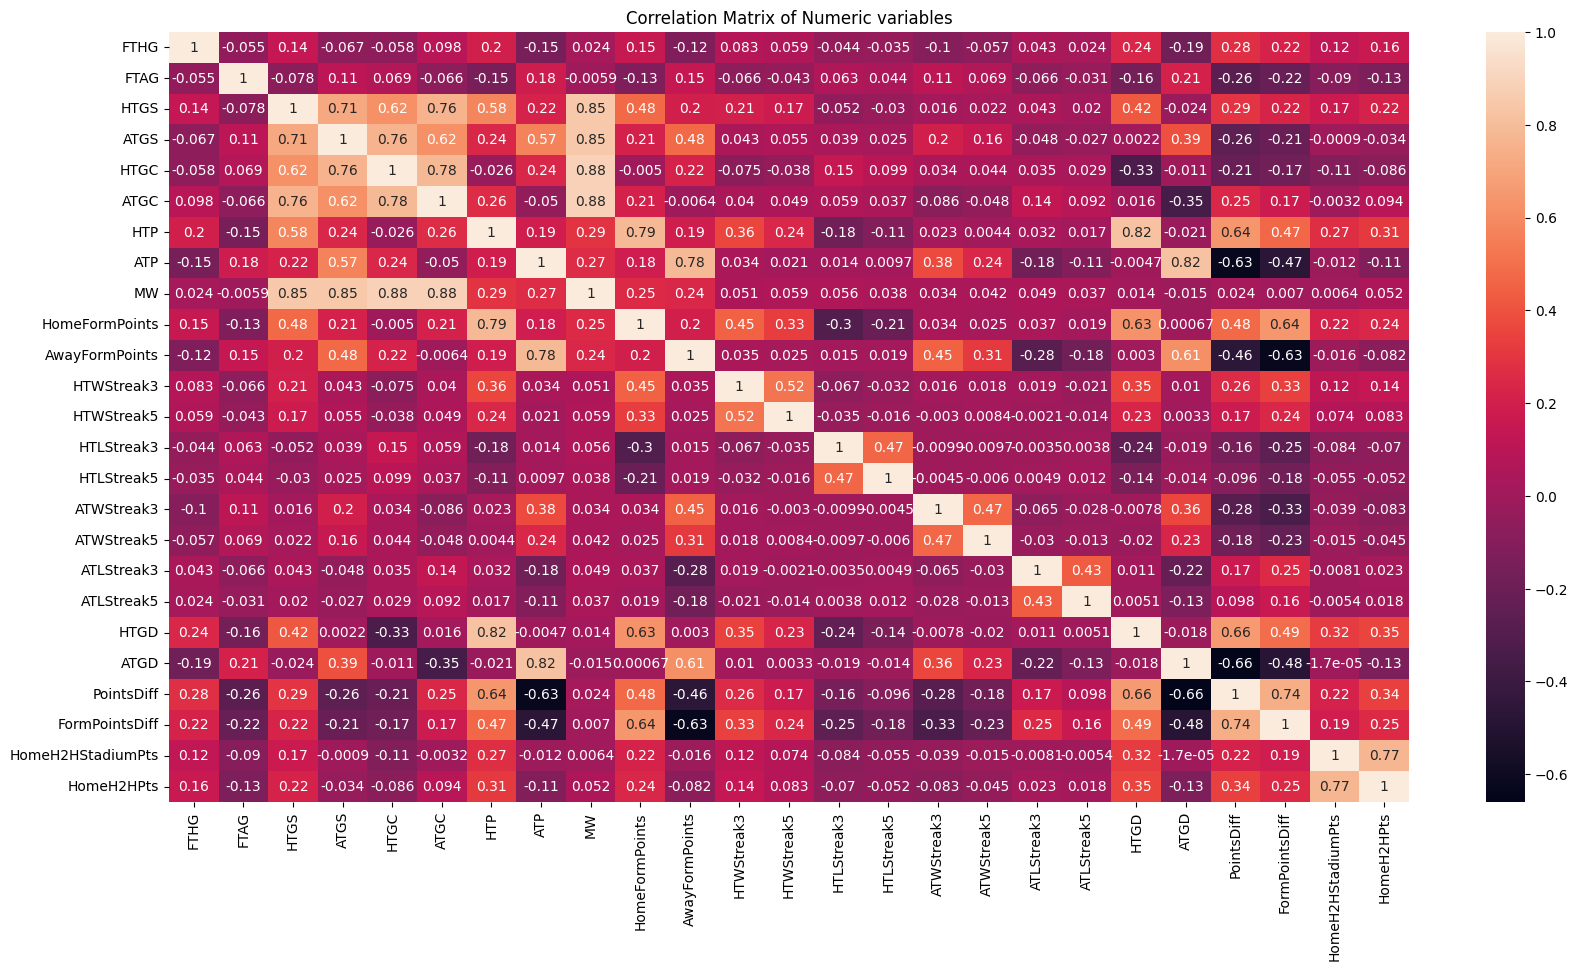

In [25]:
plt.figure(figsize = (20,10))
plt.title('Correlation Matrix of Numeric variables')
sns.heatmap(df.corr(numeric_only=True), annot= True)
plt.savefig('Plots/correlation_matrix.png')

In [26]:
df.to_csv('Data/combined_data.csv', index=None)

In [27]:
# Remove highly correlated Columns
df.drop(['Date','HomeTeam','AwayTeam'], axis=1, inplace=True)
to_drop = ['FTHG', 'FTAG', 'MW', 'Season', 'HomeForm', 'AwayForm', 'HTGS', 'HTGC', 'ATGS', 'ATGC', 'HM4', 'HM5', 'AM4', 'AM5', 'HT_H2HStadium', 'HT_H2HOverall']
df['FTR'] = df['FTR'].apply(home_nhome)
df = df.drop(to_drop, axis=1)
df.to_csv('Data/processed_data.csv', index=None)